Part 2 of my Analysis: Temporal Generalization

In this section, I conduct a temporal generalization analysis on my data. In this analysis, a model is trained at every timepoint and then tested at every other timepoint in the trial. This leads to a matrix of training and testing times where every timepoint is represented, allowing for a fuller view of the temporal structure of the data. The results of this model have already been produced and are being loaded in from another script. The goal here specifically is to first visualize the data, and second, apply a bayesfactor test to the data. In this case, instead of applying this test at every timepoint in the trial, I apply it for every point in the matrix (this is a substantially greater amount of tests!)



In [1]:
"""Load in the initial file paths
This time, the data consists of a matrix of training times produced for every subject
"""

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
top_dir = '/Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project' ##EDIT THIS LINE TO REPRODUCE
output_dir = os.path.join(top_dir, 'plots')
data_dir = os.path.join(top_dir, 'data')
times_dir = os.path.join(top_dir, 'times') #Files containing objects with timepoints in trials for plotting
file_path_times = os.path.join(times_dir, 'TimesForPlots.npy')
times = np.load(file_path_times)
# Paths
print(output_dir)




/Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project/plots


Section 1: Running Statistics

The approach to running the BayesFactor test is fundamentally the same as in the previous script, but this time a BayesFactor score must be computed for everypoint in the matrix. This changes the way that the data must ultimately be visualized.

In [ ]:
#Importing in necessary packages to apply BayesFactor
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from matplotlib.colors import LogNorm

"""Run BF Analysis on the temporal generalization matrix"""
"""Note that this script takes a while to run. If you prefer, the output of it is already in the data folder"""

#Library path to r (MUST BE ADJUSTED IF R IS IN A DIFFERENT ENVIRONMENT!)
conversion.set_conversion(default_converter + pandas2ri.converter)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")
print("R packages loaded successfully.") #If this step fails, check where your local R directory is set. This varies by operating system

# Parameters - Justification for choices is the same as in the previous script
chance = 1 / 16
mu = 0
nullMin = 0.5
nullMax = float('inf')
rscale = 'medium'
start_time = -0.2
end_time = 0.6
n_timepoints = 961
times = np.linspace(start_time, end_time, n_timepoints)


# Load all subjects
def load_tempgen_data(data_dir):
    subject_mats = []
    subject_ids = []
    for subj_num in range(1, 21):  # S01–S20
        subj = f"S{subj_num:02d}"
        file_path = os.path.join(data_dir, f"{subj}_trainTime_data.npy")
        if os.path.exists(file_path):
            mat = np.load(file_path)
            subject_mats.append(mat)
            subject_ids.append(subj)
    subject_mats = np.array(subject_mats)  # shape (n_subjects, train, test)
    print(f"Loaded {len(subject_ids)} subjects with shape {subject_mats.shape}")
    return subject_mats, subject_ids

data_all, subject_ids = load_tempgen_data(data_dir)

# Compute Bayes Factors matrix
def compute_bayes_factors_tempgen(data_all):
    """
    Here, I compute the BF for each [train, test] pair across subjects.
    data_all: shape (n_subjects, train_time, test_time)
    """
    n_subjects, n_train, n_test = data_all.shape
    bf_matrix = np.zeros((n_train, n_test))

    # normalize by chance
    normalized = data_all - chance

    print("Computing Bayes Factors")
    for i in range(n_train):
        if i % 100 == 0:
            print(f"Training time {i}/{n_train}") #This is just a print statement to check progress (it takes a while)
        for j in range(n_test):
            # Data across subjects for one train/test time pair
            sample_data = normalized[:, i, j]
            df = pd.DataFrame({'x': sample_data})

            with localconverter(ro.default_converter + pandas2ri.converter):
                r_vector = ro.conversion.py2rpy(df['x'])

            result = bayesfactor.ttestBF(
                x=r_vector,
                mu=mu,
                rscale=rscale,
                nullInterval=ro.FloatVector([nullMin, nullMax])
            )

            bf_value = np.array(ro.r['as.vector'](result))[0]
            bf_matrix[i, j] = bf_value

    return bf_matrix

#Compute the bayes factor matrix
bf_matrix = compute_bayes_factors_tempgen(data_all)

# Compute group mean accuracy 
mean_tempgen = data_all.mean(axis=0)

# Save results   
np.save(os.path.join(data_dir, "BF_matrix.npy"), bf_matrix)
#Note that you may want to skip running this part as it takes a long time. The output is saved in the data folder already.


Section 2: Visualizing the Matrix

Now we have both the decoding results, and the bayesfactor results, inside of a matrix for all training and testing times. The final step is to visualize these side by side to infer some conclusions about the data.

Loaded 20 subjects with shape (20, 961, 961)


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_24601/2064025011.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper left", fontsize=8, frameon=True)


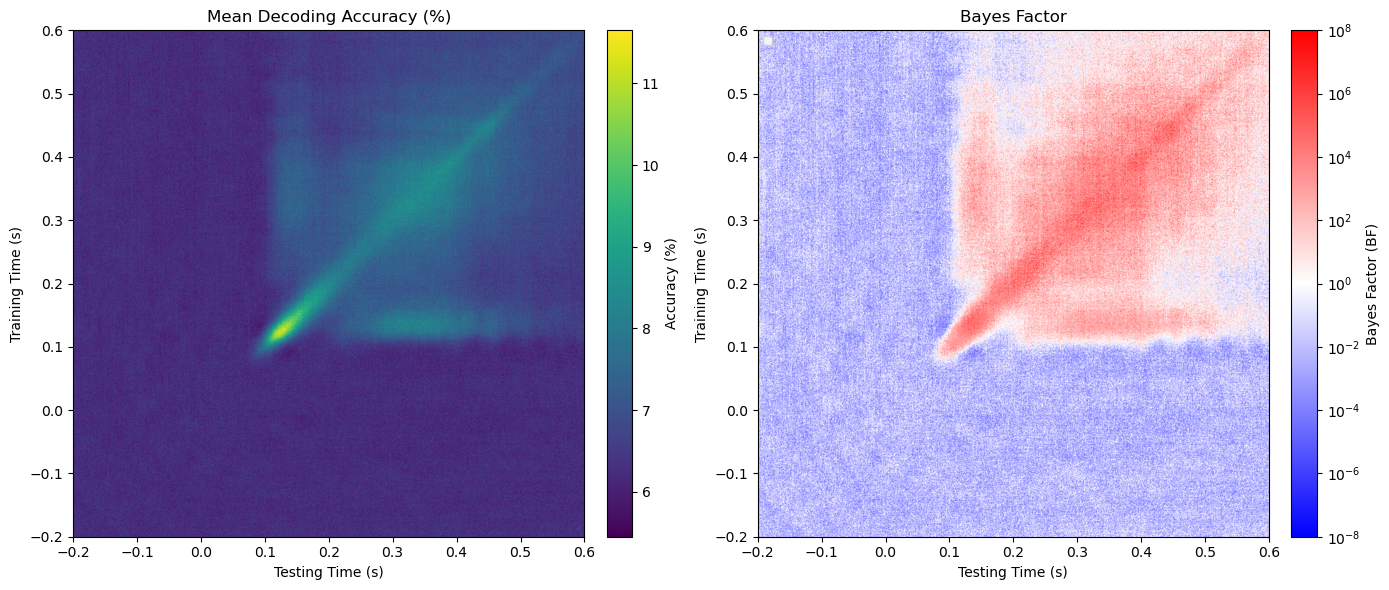

Plot saved to /Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project/plots/Figure2a_TempGen_BF_Analysis.png


In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_tempgen_data(data_dir):
    subject_mats = []
    subject_ids = []
    for subj_num in range(1, 21):  # S01–S20
        subj = f"S{subj_num:02d}"
        file_path = os.path.join(data_dir, f"{subj}_trainTime_data.npy")
        if os.path.exists(file_path):
            mat = np.load(file_path)
            subject_mats.append(mat)
            subject_ids.append(subj)
    subject_mats = np.array(subject_mats)  # shape (n_subjects, train, test)
    print(f"Loaded {len(subject_ids)} subjects with shape {subject_mats.shape}")
    return subject_mats, subject_ids

data_all, subject_ids = load_tempgen_data(data_dir)
bf_matrix = np.load(os.path.join(data_dir, "BF_matrix.npy"))
mean_tempgen = data_all.mean(axis=0)

def plot_bf_tempgen(mean_mat, bf_mat, times, save_dir):
    log_bf = np.log10(bf_mat)
    vmin, vmax = -8, 8
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Mean decoding accuracy
    im1 = ax1.imshow(mean_mat * 100, origin='lower', 
                     extent=[times[0], times[-1], times[0], times[-1]],
                     cmap='viridis', aspect='auto')
    ax1.set_title('Mean Decoding Accuracy (%)')
    ax1.set_xlabel('Testing Time (s)')
    ax1.set_ylabel('Training Time (s)')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Accuracy (%)')

    # Bayes Factor
    im2 = ax2.imshow(log_bf, origin='lower', 
                     extent=[times[0], times[-1], times[0], times[-1]],
                     cmap='bwr', norm=norm, aspect='auto')
    ax2.set_title('Bayes Factor')
    ax2.set_xlabel('Testing Time (s)')
    ax2.set_ylabel('Training Time (s)')

    ax2.legend(loc="upper left", fontsize=8, frameon=True)


    # Custom colorbar labels
    cbar = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    ticks = np.arange(vmin, vmax + 1, 2)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"$10^{{{int(t)}}}$" for t in ticks])
    cbar.set_label('Bayes Factor (BF)', fontsize=10)
    plt.tight_layout()
    save_path = os.path.join(output_dir, 'Figure2a_TempGen_BF_Analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print(f"Plot saved to {save_path}")



plot_bf_tempgen(mean_tempgen, bf_matrix, times, output_dir)

The above plot show both the temporal generalization matrix of decoding and of bayes factors for every training and testing timepoint during a trial. We can see that models trained on timepoints before stimulus onset, and roughly 80ms affter stimulus onset, have decoding at chance level and BFs that indicate evidence for the null hypothesis. Again, this is expected, because before visual content is on the screen or has had time to make it through the visual system, the model should fail to detect anything about head-orientation.

We see that models trained at 90ms and later into the trial begin to show strong evidence for A1, which is that decoding is above chance. In particular, models trained very early on in the trial show strong decoding for similar testing times, but they are not as generalizable: they fall back to chance around 100-200ms. Models trained on later timepoints are more broadly generalizable: in particular, modles traiend from around 200-400ms show broad generalizability throughout the rest of the trial including past stimulus offset, evidenced by strong evidence for the alternative hypothesis across testing times.

We can conclude from this data that visual information about head-orientation is most stable at later timepoints. This suggests that models trained on later timepoints will perform best when cross-decoding data from movie trials, whereas models trained at early timepoints may represent specific early visual processes that are unique to the static onset of a visual stimulus.


Section 3 (Bonus Visualization)

In the above analysis, we looked at the BF for each timepoint in a temporal generalization matrix. However, it could be useful to visualize this by diving regions of the matrix into sections: evidence for the null, inconclusive, and evidence for the alternative, defined the same way we did as part 1. Below is a bonus visualization that shows this.

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_24601/3580545015.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdBu', 3)


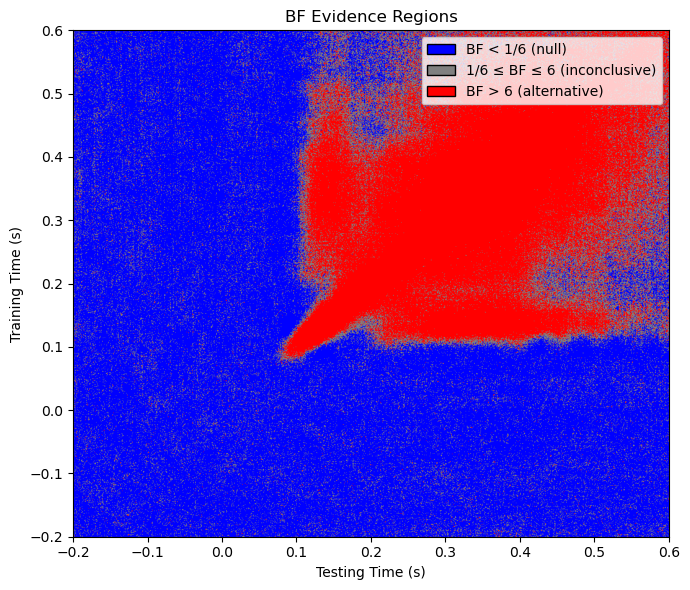

Plot saved to /Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project/plots/Figure2bBF_thresholded.png


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bf_thresholded(bf_mat, times, save_dir):
    # Define thresholds for inconclusive region
    lower = 1/6 
    upper = 6
    
    # 0 = evidence for null (BF < 1/6)
    # 1 = inconclusive (1/6 <= BF <= 6)
    # 2 = evidence for alternative (BF > 6)
    mask = np.zeros_like(bf_mat)
    mask[bf_mat > upper] = 2
    mask[(bf_mat >= lower) & (bf_mat <= upper)] = 1
    mask[bf_mat < lower] = 0

    # Define colors for each region
    cmap = plt.cm.get_cmap('RdBu', 3) 
    colors = ['blue', 'gray', 'red']   # null, inconclusive, alternative
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(mask, origin='lower', 
                   extent=[times[0], times[-1], times[0], times[-1]],
                   cmap=cmap, aspect='auto')
    
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('BF Evidence Regions')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', edgecolor='k', label='BF < 1/6 (null)'),
        Patch(facecolor='gray', edgecolor='k', label='1/6 ≤ BF ≤ 6 (inconclusive)'),
        Patch(facecolor='red', edgecolor='k', label='BF > 6 (alternative)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    folder = os.path.join(output_dir)
    os.makedirs(folder, exist_ok=True)

    # File path
    save_path = os.path.join(folder, 'Figure2bBF_thresholded.png')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to {save_path}")

plot_bf_thresholded(bf_matrix, times, output_dir)


Final Project Thoughts: Overall, my analysis was fairly successful in that I found the expected results given the setup of my experiment: strong evidence for the null prior to the onset of the stimulus, and evidence for the alternatie hypothesis after the onset of the stimulus and a period of around 89ms of neural processing latency. One aspect of the results I was less sure about was the power analysis, since I found such high probabilities throughout, which made me think I might have done something wrong. 